### Dataset "3 Kinds of Pneumonia" from Kaggle 
Link: https://www.kaggle.com/datasets/artyomkolas/3-kinds-of-pneumonia<br>
_________________
<table align="left">
    <tr>
        <th>Imagens Normais</th>
        <th>Imagens de Pneumonia Bacterial</th>
        <th>Imagens de Pneumonia Viral</th>
        <th>Imagens de COVID-19</th>
        <th>Total de Imagens</th>
    </tr>
    <tr>
        <td style="text-align: center;">3270</td>
        <td style="text-align: center;">3001</td>
        <td style="text-align: center;">1656</td>
        <td style="text-align: center;">1281</td>
        <td style="text-align: center;">9208</td>
    </tr>
</table>

In [30]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
from progressbar import AnimatedMarker, Bar, ETA, FileTransferSpeed, Percentage, ProgressBar
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Carregamento dos Dados

In [75]:
datadir = "C:\\Users\\robso\\CNN Brain Tumor\\Brain Tumor Data Set\\"
categories = ['Healthy', 'Brain Tumor']
x = []
y = []

for category in categories:
    widget = [f"Loading class '{category}': \t", Percentage(), Bar(marker=AnimatedMarker()), " \t", ETA(), " \t", FileTransferSpeed()]
    pbar = ProgressBar(widgets=widget)
    path = os.path.join(datadir, category)
    
    for (i, file) in enumerate(pbar(os.listdir(path))):
        image = cv2.imread(os.path.join(path, file), cv2.IMREAD_GRAYSCALE)
        image = resize(image, (256, 256, 3), mode = 'constant', preserve_range = True)
        image = np.array(image)
        image = image.astype('float32')
        image /= 255
        x.append(image)
        y.append(categories.index(category))

Loading class 'Healthy': 	100%||||||||||||||||||||| 	Time: 0:00:47 	 43.84  B/s
Loading class 'Brain Tumor': 	100%||||||||||||||||| 	Time: 0:01:08 	 36.83  B/s


### Divisão do Conjunto de Dados

In [79]:
x = np.array(x)
y = np.array(y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

### Arquitetura da CNN

In [80]:
#tf.random.set_seed(42)
#np.random.set_seed(42)

#kfold = KFold(n_splits=5, shuffle=True)
#acc_fold = []
#loss_fold = []

model = Sequential()

model.add(Flatten(input_shape=(256,256,3)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_19 (Flatten)         (None, 196608)            0         
_________________________________________________________________
dense_47 (Dense)             (None, 128)               25165952  
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 129       
Total params: 25,166,081
Trainable params: 25,166,081
Non-trainable params: 0
_________________________________________________________________


### Treinamento da CNN

In [81]:
results = model.fit(x_train, y_train, epochs=10, validation_data=(x_test,y_test))

Epoch 1/10
115/115 [==============================] - 37s 238ms/step - loss: 3.9371 - accuracy: 0.5693 - val_loss: 0.5290 - val_accuracy: 0.7250
Epoch 2/10
115/115 [==============================] - 21s 181ms/step - loss: 0.5443 - accuracy: 0.7076 - val_loss: 0.4893 - val_accuracy: 0.8228
Epoch 3/10
115/115 [==============================] - 17s 152ms/step - loss: 0.5001 - accuracy: 0.7540 - val_loss: 0.4795 - val_accuracy: 0.7641
Epoch 4/10
115/115 [==============================] - 17s 149ms/step - loss: 0.4681 - accuracy: 0.7481 - val_loss: 0.4461 - val_accuracy: 0.7859
Epoch 5/10
115/115 [==============================] - 17s 150ms/step - loss: 0.4196 - accuracy: 0.7494 - val_loss: 0.3325 - val_accuracy: 0.8402
Epoch 6/10
115/115 [==============================] - 18s 160ms/step - loss: 0.3894 - accuracy: 0.7666 - val_loss: 0.3120 - val_accuracy: 0.8859
Epoch 7/10
115/115 [==============================] - 17s 152ms/step - loss: 0.3580 - accuracy: 0.8408 - val_loss: 0.2756 - val_ac

### Teste da CNN

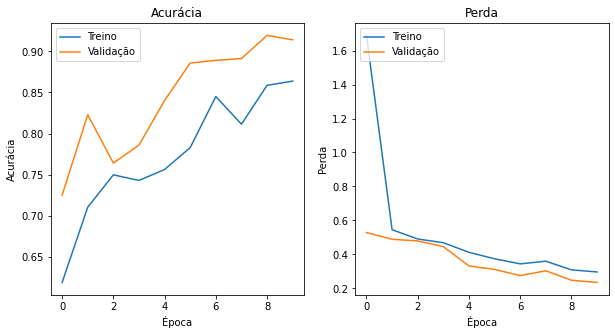

In [82]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title('Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.legend(['Treino', 'Validação'], loc='upper left')

plt.subplot(122)
plt.title('Perda')
plt.ylabel('Perda')
plt.xlabel('Época')
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.legend(['Treino', 'Validação'], loc='upper left')

plt.show()

Métrica de avaliação		Resultado
---------------------------------------------
Acurácia:		 91.41304347826087 %
Precisão:		 95.75371549893843 %
Sensibilidade:		 88.43137254901961 %
Especificidade:		 95.1219512195122 %


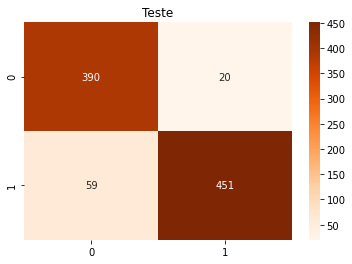

In [83]:
y_pred = model.predict(x_test)
y_pred = np.round(y_pred)

cmat=confusion_matrix(y_test,y_pred,labels=[0,1])
cm_df = pd.DataFrame(cmat)

tp = cmat[1][1]
fp = cmat[0][1]
tn = cmat[0][0]
fn = cmat[1][0]

accuracy = ((tp+tn)*100)/np.sum(cmat)
precision = (tp*100)/(tp+fp)
sensibility = (tp*100/(tp+fn))
specificity = (tn*100)/(fp+tn)

print('Métrica de avaliação\t\tResultado')
print('---------------------------------------------')
print('Acurácia:\t\t',accuracy,"%")
print('Precisão:\t\t',precision,"%")

print('Sensibilidade:\t\t',sensibility,"%")
print('Especificidade:\t\t',specificity,"%")
                   
plt.title('Teste')
sns.heatmap(cm_df, annot=True, fmt="d", cmap=plt.cm.Oranges)
plt.show()